In [1]:
import pandas as pd
import numpy as np
import meshio
import os
import glob
import re

In [2]:
dir = "output"
with open("./data/gen_log.txt") as f:
    text = f.read()

# param_pat = re.compile(r"(\w+)\s*[:=]\s*(\d+)")
# params = {key: int(val) for key, val in param_pat.findall(text)}

comb_match = re.search(r'^combination\s*[:=]\s*(\d+)', text, re.MULTILINE)
combination = comb_match.group(1) if comb_match else None

scalar_keys = ("n_obs_per_clust", "n_clust", "N", "seed")
scalar_pat  = rf'^({"|".join(scalar_keys)})\s*[:=]\s*(\d+)\s*$'
scalars = {k: int(v) for k, v in re.findall(scalar_pat, text, re.MULTILINE)}

n_obs_per_clust = scalars["n_obs_per_clust"]
n_clust         = scalars["n_clust"]
N               = scalars["N"]
seed            = scalars["seed"]

print("combination     =", combination)        
print("n_obs_per_clust =", n_obs_per_clust)    
print("n_clust         =", n_clust)            
print("N               =", N)                  
print("seed            =", seed)               

combination     = 021102
n_obs_per_clust = 30
n_clust         = 3
N               = 50
seed            = 773623948


In [3]:
s = 12 # between 0 and N-1
u = "true"

In [4]:
block = re.search(r"u:\s*\[\s*([\s\S]*?)\]", text).group(1)
nums  = [float(x) for x in re.findall(r"-?\d+\.\d+(?:[eE][+-]?\d+)?", block)]
if u == "true":
    u = np.array(nums)[s]
else:
    u = 0.5
print("u               =", u)

u               = 0.483488


In [5]:
output_dir = "output/reg/3d/gauss"
data_dir = "data/3d"

responses = pd.read_csv(os.path.join(data_dir, f"gauss/gauss_{s}.csv"), header=None)
centroids = pd.read_csv(os.path.join(output_dir, "centroids.csv"), header=None)
centroids_scatter = pd.read_csv(os.path.join("output/missing/3d/scatter/gauss", "centroids.csv"), header=None)
centroids_area = pd.read_csv(os.path.join("output/missing/3d/area/gauss", "centroids.csv"), header=None)
scatter_pattern = pd.read_csv(os.path.join(data_dir, f"observation_patterns/scatter/scatter_{s}.csv"), header=None)
area_pattern = pd.read_csv(os.path.join(data_dir, f"observation_patterns/area/area_{s}.csv"), header=None)

nodes = pd.read_csv(os.path.join(data_dir, "nodes.csv"), header=None).values
elem = pd.read_csv(os.path.join(data_dir, "cells.csv"), header=None).values
cells = [("tetra", elem)]

gauss_3d = lambda x, y, z: np.exp(-((x - 0.5)**2 + (y - 0.5)**2 + (z - 0.5)**2) / 0.1)
gauss_3d_s1 = lambda x, y, z: gauss_3d(x - 0.1, y, z)
gauss_3d_s2 = lambda x, y, z: gauss_3d(x + 0.1, y, z)

x = nodes[:, 0]
y = nodes[:, 1]
z = nodes[:, 2]
generating_1 = u*gauss_3d(x, y, z) + (1-u)*gauss_3d_s1(x, y, z)
generating_2 = u*gauss_3d_s2(x, y, z) + (1-u)*gauss_3d(x, y, z)
generating_3 = u*gauss_3d_s1(x, y, z) + (1-u)*gauss_3d_s2(x, y, z)

point_data = {}

for i in range(n_clust):
    point_data[f"sample_{i}"] = responses.iloc[i*n_obs_per_clust, :].values.flatten()
for i in range(n_clust):
    point_data[f"centroid_{i+1}"] = centroids.iloc[s*n_clust + i, :].values.flatten()
for i in range(n_clust):
    point_data[f"generating_{i+1}"] = [generating_1, generating_2, generating_3][i]
for i in range(n_clust):
    point_data[f"centroid_scatter_{i+1}"] = centroids_scatter.iloc[s*n_clust + i, :].values.flatten()
for i in range(n_clust):
    point_data[f"centroid_area_{i+1}"] = centroids_area.iloc[s*n_clust + i, :].values.flatten()
point_data["scatter_pattern"] = scatter_pattern.iloc[0, :].values.flatten()
point_data["area_pattern"] = area_pattern.iloc[0, :].values.flatten()


In [6]:
mesh = meshio.Mesh(points=nodes, cells=cells, point_data=point_data)
mesh.write(os.path.join("mesh_3d.vtu"))

In [9]:
# Application:
# nodes of the brain mesh
# elemments of the brain mesh
# sample from schz and control
# centroids from k_2 run_8 of output or k_2 run_1 of output_2

n = 0 #4, 5

nodes = pd.read_csv("./application/data/mesh/points.csv", header=0, index_col=0).values
elem = pd.read_csv("./application/data/mesh/elements.csv", header=0, index_col=0)
# subtract 1 from all the elements pointwides to convert from 1-based to 0-based indexing
elem_values = elem.values - 1
cells = [("tetra", elem_values)]

point_data = {}

point_data["schz_sample"] = pd.read_csv("./application/data/z_map_SCHZ.csv", header=0, index_col=0).iloc[n, :].values.flatten()
point_data["ctrl_sample"] = pd.read_csv("./application/data/z_map_CONTROL.csv", header=0, index_col=0).iloc[n, :].values.flatten()
point_data["centroid_1"] = pd.read_csv("./application/output/runs/k_2/run_9/centroids.csv", header=None).iloc[0, :].values.flatten()
point_data["centroid_2"] = pd.read_csv("./application/output/runs/k_2/run_9/centroids.csv", header=None).iloc[1, :].values.flatten()
point_data["schz_mean"] = pd.read_csv("./application/data/z_map_SCHZ.csv", header=0, index_col=0).mean(axis=0).values.flatten()
point_data["ctrl_mean"] = pd.read_csv("./application/data/z_map_CONTROL.csv", header=0, index_col=0).mean(axis=0).values.flatten()

mesh = meshio.Mesh(points=nodes, cells=cells, point_data=point_data)
mesh.write(os.path.join("application.vtu"))

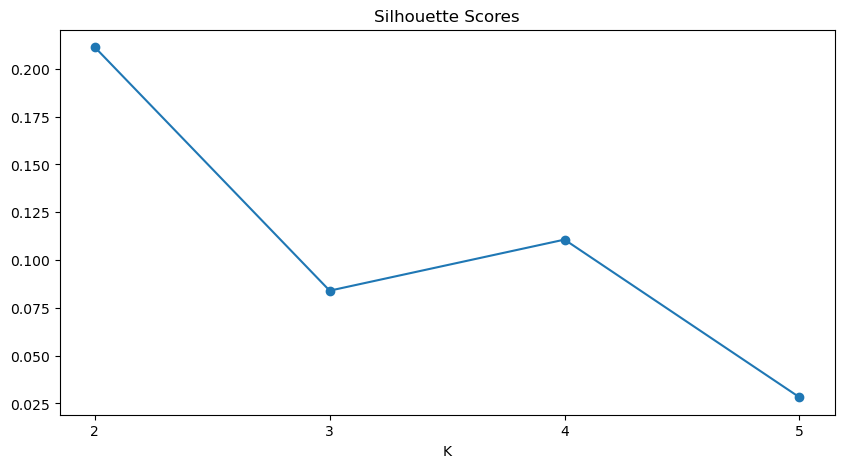

In [5]:
#Siluette score image
import matplotlib.pyplot as plt
sil = pd.read_csv("./application/output/siluette_scores.csv", header=None)
plt.figure(figsize=(10,5))
plt.plot(sil.iloc[:, 0], sil.iloc[:, 1], marker='o')
plt.title("Silhouette Scores")
plt.xlabel("K")
plt.xticks([2,3,4,5])
plt.savefig("silhouette_scores.png", dpi=300)
plt.show()